# Read in the data

In [38]:
import pandas as pd
import numpy
import re
import matplotlib as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [39]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [40]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [41]:
data["hs_directory"]["Location 1"].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object

In [42]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [43]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [44]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [45]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [46]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [47]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [48]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [49]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

In [50]:
corr_score_survey = combined.corr()['sat_score'][survey_fields]

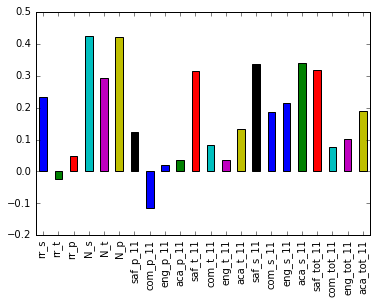

In [51]:
corr_score_survey.plot(kind = 'bar')

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. Students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

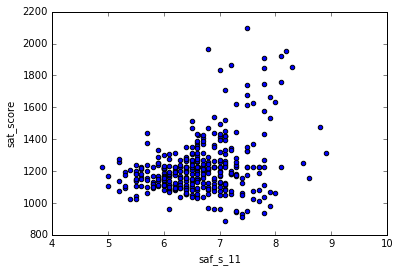

In [52]:
combined.plot('saf_s_11', 'sat_score', kind = 'scatter')

The correlation does not appear to be that strong between SAT scores and safety. There are a few schools that appear in the upper right hand corner and the lower left hand corner that agree with the theory that safety score is correlated with sat score 

# Plot the School Districts on a Map with the Safety as a Color

In [53]:
combined.columns.values

array(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName',
       'AP Test Takers ', 'Total Exams Taken',
       'Number of Exams with scores 3 4 or 5', 'Demographic',
       'School Name', 'Cohort', 'Total Cohort', 'Total Grads - n',
       'Total Grads - % of cohort', 'Total Regents - n',
       'Total Regents - % of cohort', 'Total Regents - % of grads',
       'Advanced Regents - n', 'Advanced Regents - % of cohort',
       'Advanced Regents - % of grads', 'Regents w/o Advanced - n',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - n',
       'Local - % of cohort', 'Local - % of grads', 'Still Enrolled - n',
       'Still Enrolled - % of cohort', 'Dropped Out - n',
       'Dropped Out - % of cohort', 'CSD',
       'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALL

In [54]:
#groupby district and take the mean of every column
district = combined.groupby(combined['school_dist']).agg(numpy.mean)
district.reset_index(inplace = True)
district

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
5,06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
7,08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
8,09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,10.0,...,12.0,12.0,10463.181818,757.863636,1.500000,0.0,0.0,0.0,40.870345,-73.898360


In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

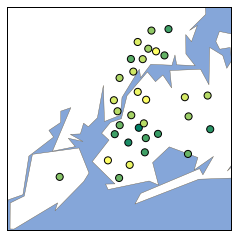

In [56]:
# create variable with type of projection, resolution, and the latitiude and longitudes of the plot
m = Basemap(
    projection = 'merc',
    resolution = 'i',
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272
)

# draw in boundaries, coastlines, rivers, and fill the continent with a color. 
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

# change the lon and lat to lists called longitude and latitude respectively
# scatter only takes series. if just "district['lon']", then still a pandas dataframe
# must convert to series (list) first

longitude = district['lon'].tolist()
latitude = district['lat'].tolist()

# create a colored scatter plot
# longitude first, then latitude
# s is size of bullet
# zorder determines where the method draws the points on the z axis. 
# In other words, it determines the order of the layers on the map.
# c is color sequence
# cmap is color map
m.scatter(longitude, latitude, s=50, zorder=2, latlon = True, c= district['saf_s_11'], cmap='summer')
plt.show()

Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores. Brooklyn has low safety scores.

# Investigate Racial differences

In [57]:
race = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

In [58]:
race_corr = combined.corr()['sat_score'][race]

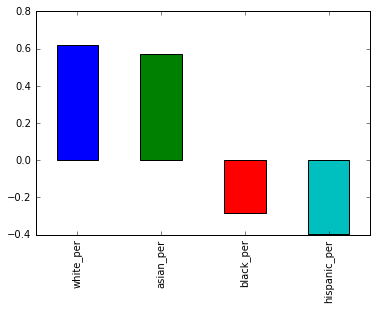

In [59]:
race_corr.plot(kind='bar')

Seems like schools with a higher percentage of white and asian students are corrleated with higher SAT scores. Schools with higher black and hispanic percentages are corrrelated with lower SAT scores. Could be due to lack of funding or different neighborhoods where said schools are located

# Do a deeper dive into schools with a higher hispanic percentage

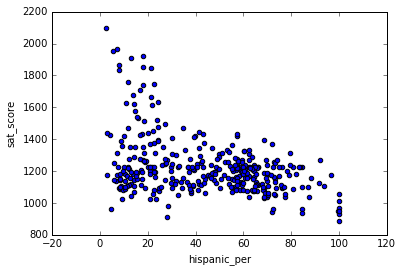

In [60]:
combined.plot('hispanic_per', 'sat_score', kind= 'scatter')

Some correlation, but it doesn't seem definitive. Low scores throughout the hispanic percentage 

In [61]:
combined[['SCHOOL NAME', 'SchoolName']].head()

,SCHOOL NAME,SchoolName
0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,0
1,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,UNIVERSITY NEIGHBORHOOD H.S.
2,EAST SIDE COMMUNITY SCHOOL,EAST SIDE COMMUNITY HS
3,MARTA VALLE HIGH SCHOOL,0
4,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...","NEW EXPLORATIONS SCI,TECH,MATH"


In [62]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME'].value_counts()

WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL            1
INTERNATIONAL SCHOOL FOR LIBERAL ARTS                       1
PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE            1
MANHATTAN BRIDGES HIGH SCHOOL                               1
ACADEMY FOR LANGUAGE AND TECHNOLOGY                         1
GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS    1
PAN AMERICAN INTERNATIONAL HIGH SCHOOL                      1
MULTICULTURAL HIGH SCHOOL                                   1
Name: SCHOOL NAME, dtype: int64

The schools listed above seem to be geared towards recent immigrants. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [63]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME'].value_counts()

BRONX HIGH SCHOOL OF SCIENCE                           1
QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE    1
STUYVESANT HIGH SCHOOL                                 1
STATEN ISLAND TECHNICAL HIGH SCHOOL                    1
BROOKLYN TECHNICAL HIGH SCHOOL                         1
Name: SCHOOL NAME, dtype: int64

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Investigate Gender Differences

In [64]:
gender = ['male_per', 'female_per']

In [65]:
corr_gender = combined.corr()['sat_score'][gender]

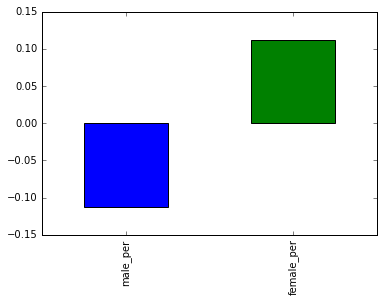

In [66]:
corr_gender.plot(kind='bar')

Seems like males are negatively correlated and females are positvely correlated. a little

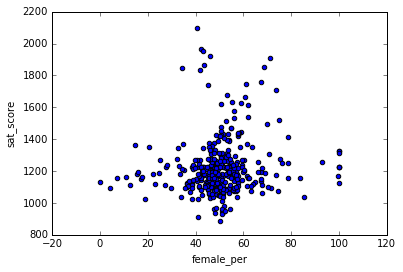

In [67]:
combined.plot('female_per', 'sat_score', kind= 'scatter')

Scatterplot is not particularly revealing. There is a small group of schools with between 60 to 80% of females that have high SAT Score 

In [68]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

In [69]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

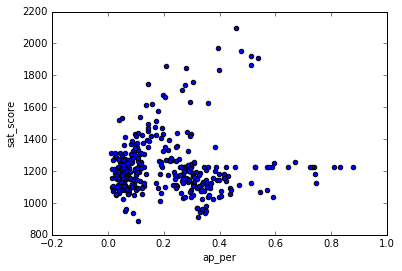

In [70]:
combined.plot('ap_per', 'sat_score', kind = 'scatter' )

Not a particularly strong correlation, but there is some

# Correlation between Class size and SAT Scores

In [81]:
class_size = ['AVERAGE CLASS SIZE', 'NUMBER OF STUDENTS / SEATS FILLED']

In [82]:
combined.corr()['sat_score'][class_size]

AVERAGE CLASS SIZE                   0.381014
NUMBER OF STUDENTS / SEATS FILLED    0.394626
Name: sat_score, dtype: float64

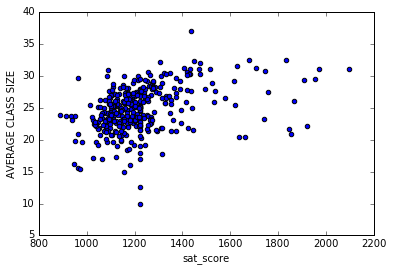

In [83]:
combined.plot('sat_score', 'AVERAGE CLASS SIZE', kind = 'scatter')

Definitely has some positive correlation, but not particularly strong. 

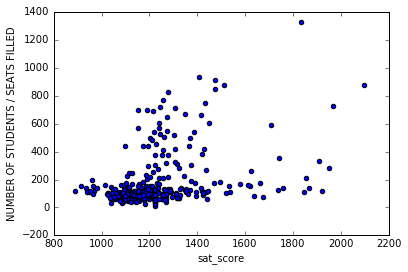

In [84]:
combined.plot('sat_score', 'NUMBER OF STUDENTS / SEATS FILLED', kind = 'scatter')

# Which neighborhoods have the best schools

In [78]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,0.305756
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,0.098985
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,0.031773
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01,0.351577
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01,0.158091


In [79]:
combined.columns.values

array(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName',
       'AP Test Takers ', 'Total Exams Taken',
       'Number of Exams with scores 3 4 or 5', 'Demographic',
       'School Name', 'Cohort', 'Total Cohort', 'Total Grads - n',
       'Total Grads - % of cohort', 'Total Regents - n',
       'Total Regents - % of cohort', 'Total Regents - % of grads',
       'Advanced Regents - n', 'Advanced Regents - % of cohort',
       'Advanced Regents - % of grads', 'Regents w/o Advanced - n',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - n',
       'Local - % of cohort', 'Local - % of grads', 'Still Enrolled - n',
       'Still Enrolled - % of cohort', 'Dropped Out - n',
       'Dropped Out - % of cohort', 'CSD',
       'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALL

In [80]:
combined['boro'].value_counts()

Brooklyn         106
Bronx             93
Manhattan         90
Queens            64
Staten Island     10
Name: boro, dtype: int64

In [94]:
boro_averages = combined.groupby('boro').apply(numpy.mean).reset_index()

In [95]:
boro_averages.head()

,boro,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon,ap_per
0,Bronx,384.050714,393.891831,379.655657,1157.598203,96.473842,149.445409,135.694086,136.857093,9.548387,...,12.0,10461.408602,549.569892,1.344086,0.0,0.0,0.0,40.845473,-73.890973,0.189331
1,Brooklyn,391.336947,404.612644,385.414869,1181.364461,131.645682,202.857765,164.940094,183.870968,18.000000,...,12.0,11216.150943,751.556604,1.971698,0.0,0.0,0.0,40.665555,-73.947829,0.217670
2,Manhattan,421.070149,437.824710,419.436551,1278.331410,126.135363,192.661966,153.337778,155.421505,2.900000,...,12.0,10024.744444,633.588889,1.433333,0.0,0.0,0.0,40.766244,-73.975350,0.246578
3,Queens,422.274953,448.207556,416.270522,1286.753032,160.463942,238.014423,153.975000,307.208165,26.906250,...,12.0,11343.000000,1187.187500,2.390625,0.0,0.0,0.0,40.715715,-73.836422,0.184006
4,Staten Island,457.500000,472.500000,452.500000,1382.500000,228.908654,355.111538,194.435000,450.787097,31.000000,...,12.0,10307.100000,1847.500000,5.000000,0.0,0.0,0.0,40.595680,-74.125726,0.176337


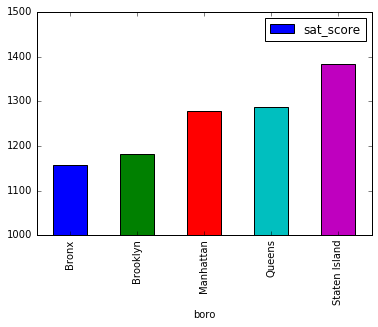

In [103]:
boro_averages.plot('boro', 'sat_score', kind = 'bar', ylim = [1000, 1500])

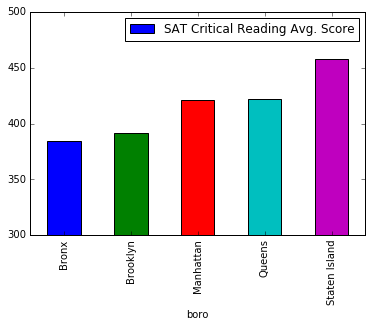

In [99]:
boro_averages.plot('boro', 'SAT Critical Reading Avg. Score', kind = 'bar', ylim = [300,500])

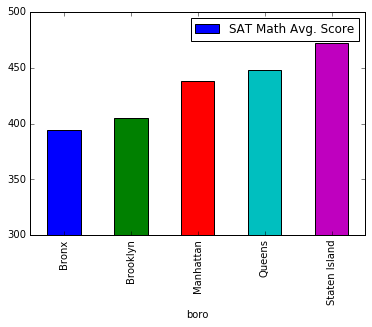

In [100]:
boro_averages.plot('boro', 'SAT Math Avg. Score', kind = 'bar', ylim = [300,500])

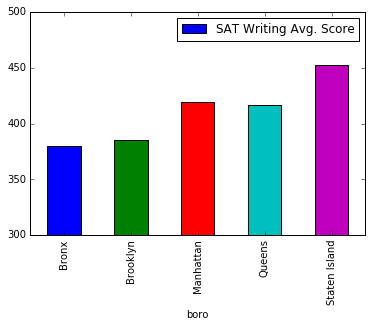

In [101]:
boro_averages.plot('boro', 'SAT Writing Avg. Score', kind = 'bar', ylim = [300,500])

Seems like Staten Island definitely has the highest performing schools (based on SAT's) in the NYC area. Finding the least expensive neighborhoods with good schools would necessitate additional data on average housing prices in the area

# Investigate the differences between parent, teacher, and student responses to surveys

In [104]:
combined.columns.values

array(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName',
       'AP Test Takers ', 'Total Exams Taken',
       'Number of Exams with scores 3 4 or 5', 'Demographic',
       'School Name', 'Cohort', 'Total Cohort', 'Total Grads - n',
       'Total Grads - % of cohort', 'Total Regents - n',
       'Total Regents - % of cohort', 'Total Regents - % of grads',
       'Advanced Regents - n', 'Advanced Regents - % of cohort',
       'Advanced Regents - % of grads', 'Regents w/o Advanced - n',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - n',
       'Local - % of cohort', 'Local - % of grads', 'Still Enrolled - n',
       'Still Enrolled - % of cohort', 'Dropped Out - n',
       'Dropped Out - % of cohort', 'CSD',
       'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALL

In [137]:
combined[['SCHOOL NAME', 'SchoolName']]

,SCHOOL NAME,SchoolName
0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,0
1,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,UNIVERSITY NEIGHBORHOOD H.S.
2,EAST SIDE COMMUNITY SCHOOL,EAST SIDE COMMUNITY HS
3,MARTA VALLE HIGH SCHOOL,0
4,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...","NEW EXPLORATIONS SCI,TECH,MATH"
5,BARD HIGH SCHOOL EARLY COLLEGE,0
6,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,0
7,FOOD AND FINANCE HIGH SCHOOL,0
8,ESSEX STREET ACADEMY,0
9,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,High School of Hospitality Management


In [115]:
combined.filter(regex = ("^saf"))

,saf_p_11,saf_t_11,saf_s_11,saf_tot_11
0,7.8,6.3,6.000000,6.7
1,7.9,6.6,6.000000,6.8
2,8.7,7.3,6.611667,7.9
3,7.7,6.4,6.400000,6.9
4,8.5,7.6,7.300000,7.8
5,8.8,8.2,8.300000,8.5
6,8.9,8.1,7.300000,8.1
7,7.6,7.3,6.200000,7.0
8,8.7,8.0,7.400000,7.9
9,8.0,8.6,7.100000,7.9


In [144]:
df = {}
survey_type = ['rr', 'saf', 'com', 'eng', 'aca']

for i in survey_type:
    df[i] = combined.filter(regex = ("^{}").format(i))

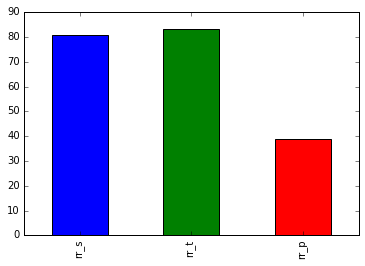

In [146]:
#Response Rate
df['rr'].mean().plot(kind = 'bar')

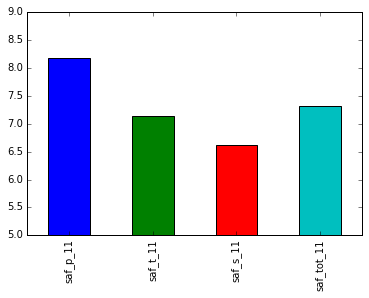

In [148]:
# Safety and Respect 
df['saf'].mean().plot(kind = 'bar', ylim = [5,9])

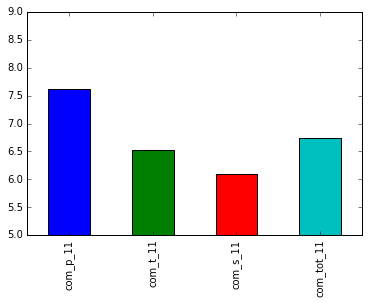

In [149]:
# Communication
df['com'].mean().plot(kind = 'bar', ylim = [5,9])

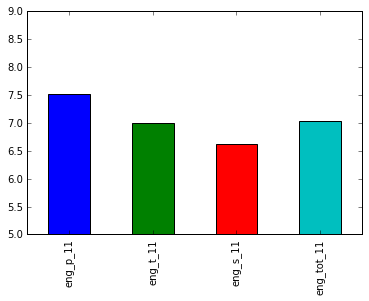

In [150]:
#Engagement
df['eng'].mean().plot(kind = 'bar', ylim = [5,9])

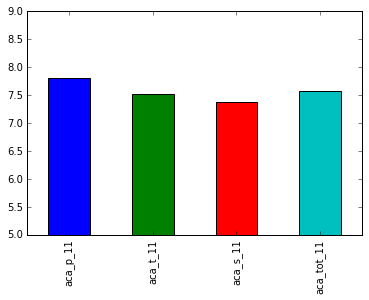

In [151]:
# Academics
df['aca'].mean().plot(kind = 'bar', ylim = [5,9])

Seems like in general, parents rate different school attributes better than teachers or students, but parents also have the lowest response rates of any of the three groups. It seems like roughly 80% of teachers and students respond while only 40% of parents respond. That may indicate that the teachers and students survey results should be trusted more than the parents. Greatest discrepancies seem to be in Safety and Communication